In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Column 1: age in years
# Column 2: 1 = male, 0 = female
# Column 3: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
# Column 4: resting blood pressure in mmHg
# Column 5: cholesterol in mg/dl
# Column 6: 1 means > 120 mg/dl, 0 means <= 120 mg/dl
# Column 7: resting electrocardiographic, 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
# Column 8: max heart rate achieved
# Column 9: 1 = yes, 2 = no
# Column 10: ST depression induced by exercise relative to rest
# Column 11: slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping
# Column 12: number of major vessels (0-3) colored by flourosopy
# Column 13: 3 = normal, 6 = fixed defect, 7 = reversable defect
# Column 14: >=1 means heart disease, 0 = no heart disease

myNames = ["age", # column 1
        "sex", # col 2
        "chestPainType", # col 3
        "restingBP", # col 4
        "serumCholesterol", # col 5
        "fastingBloodSugar", # col 6
        "restingEcg", # col 7
        "maxHeartRate", # col 8
        "exerciseInducedAngina", # col 9
        "stDepression", # col 10
        "stSlope", # col 11
        "majorVessels", # col 12
        "thalassemia", # col 13
        "diagnosis"] # col 14
assert len(myNames) == 14

data = pd.read_csv("data/processed.cleveland.data", sep=',', names=myNames, na_values=["?", '?'])
data.iloc[:, -1] = data.iloc[:, -1].clip(0, 1) # clip last column (output) between 0 and 1, both inclusive

# Feature selection
data = data.drop("fastingBloodSugar", axis=1)
myNames.remove("fastingBloodSugar")
data = data.drop("restingEcg", axis=1)
myNames.remove("restingEcg")
data = data.drop("serumCholesterol", axis=1)
myNames.remove("serumCholesterol")
data = data.drop("stSlope", axis=1)
myNames.remove("stSlope")

data = data.dropna().reset_index(drop=True)

# Convert all columns to float
for name in myNames:
    data[name] = pd.to_numeric(data[name],errors = 'coerce')

m = data.shape[0] # num examples
n = data.shape[1] - 1 # num features

print("Num features:", n)
print("Num examples:", m)
    
# a few examples from the dataset 
print()
print(data.head())

X = data.values[:, :-1]
y = data.values[:, -1:]


Num features: 9
Num examples: 297

    age  sex  chestPainType  restingBP  maxHeartRate  exerciseInducedAngina  \
0  63.0  1.0            1.0      145.0         150.0                    0.0   
1  67.0  1.0            4.0      160.0         108.0                    1.0   
2  67.0  1.0            4.0      120.0         129.0                    1.0   
3  37.0  1.0            3.0      130.0         187.0                    0.0   
4  41.0  0.0            2.0      130.0         172.0                    0.0   

   stDepression  majorVessels  thalassemia  diagnosis  
0           2.3           0.0          6.0          0  
1           1.5           3.0          3.0          1  
2           2.6           2.0          7.0          1  
3           3.5           0.0          3.0          0  
4           1.4           0.0          3.0          0  


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalization
# Binary features do not need normalization as they are already 0 or 1

numeric_features = ['age', 'restingBP', "serumCholesterol", "maxHeartRate", "stDepression", "majorVessels"]
for f in [f for f in numeric_features]:
    if f not in myNames:
        numeric_features.remove(f)
# Nominal categorical features have no hierarchical order (as opposed to [very healthy, healthy, unhealthy, very unhealthy])
nominal_categorical_features = ["chestPainType", "restingEcg", "stSlope", "thalassemia"]
for f in [f for f in nominal_categorical_features]:
    if f not in myNames:
        nominal_categorical_features.remove(f)

data_normalized = data.copy()

scaler = StandardScaler() # or MinMaxScaler()
data_normalized[numeric_features] = scaler.fit_transform(data_normalized[numeric_features])

encoder = OneHotEncoder()
nominal_cat_encoded = encoder.fit_transform(data_normalized[nominal_categorical_features])
nominal_cat_encoded = pd.DataFrame(nominal_cat_encoded.toarray(), columns=encoder.get_feature_names_out(nominal_categorical_features))

data_normalized = pd.concat([data_normalized.drop(nominal_categorical_features, axis=1), nominal_cat_encoded], axis=1)
data_normalized = data_normalized.dropna(subset=['diagnosis']) # Drop NaN diagnosis 
data_normalized = data_normalized.dropna()
print("Num features after encoding + normalization:", data_normalized.shape[1]-1)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(data_normalized.drop("diagnosis", axis=1), 
                                                data_normalized["diagnosis"], 
                                                test_size=0.25, 
                                                random_state=42)

Num features after encoding + normalization: 14


In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV

def printResults(model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Test set accuracy (% correct predicts):", round(accuracy,2))
    trainingSetAcc = model.score(X_train_scaled, y_train)
    print("Training set accuracy:", round(trainingSetAcc, 2))
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy:", round(balanced_accuracy,2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1-score:", round(f1, 2))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))

Unregularized KNN
Best hyperparameters:  {'leaf_size': 1, 'n_neighbors': 13}
Optimal classification threshold: 0.54
Test set accuracy (% correct predicts): 0.84
Training set accuracy: 0.84
Balanced accuracy: 0.83
Precision: 0.84
Recall: 0.84
F1-score: 0.84
Confusion matrix:
 [[37  5]
 [ 7 26]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86        42
           1       0.84      0.79      0.81        33

    accuracy                           0.84        75
   macro avg       0.84      0.83      0.84        75
weighted avg       0.84      0.84      0.84        75



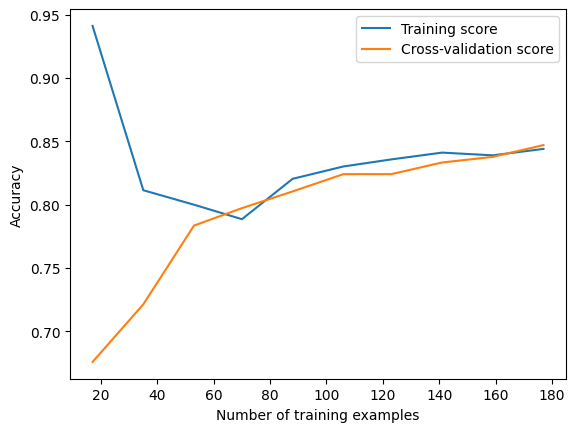

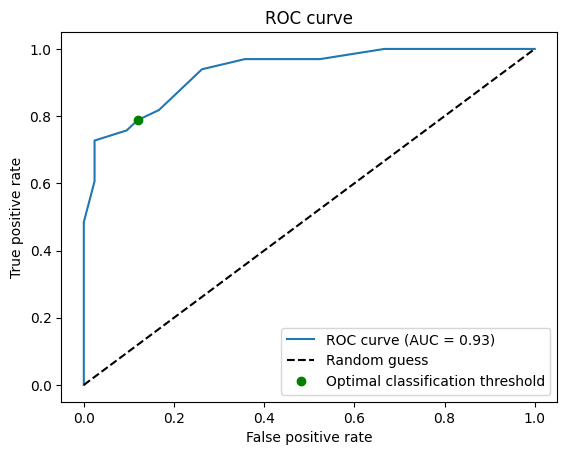

In [5]:
# Unregularized KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import auc

print("Unregularized KNN")

# Hyperparameters to tune
params = {'n_neighbors': range(1, 31, 2), # start stop step
          'leaf_size': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]}

# Unregularized KNN
knn_unreg = KNeighborsClassifier()

grid_unreg = GridSearchCV(knn_unreg, params, cv=5, n_jobs=-1)
grid_unreg.fit(X_train_scaled, y_train)
knn_unreg = grid_unreg.best_estimator_

print("Best hyperparameters: ", grid_unreg.best_params_)

# Get predicted probabilities for the test set
y_prob = grid_unreg.predict_proba(X_test_scaled)[:, 1]
# Compute false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate Euclidean distance to the top-left corner for each threshold
dist = np.sqrt(fpr**2 + (1-tpr)**2)
# Find index of threshold with minimum distance
idx = np.argmin(dist)
y_pred = (y_prob >= thresholds[idx]).astype(int)

print('Optimal classification threshold:', round(thresholds[idx], 2))

printResults(knn_unreg, y_test, y_pred)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_unreg,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate means and standard deviations for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training score")
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Compute AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.plot(fpr[idx], tpr[idx], 'go', label='Optimal classification threshold')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

Regularized KNN
Best hyperparameters:  {'leaf_size': 1, 'n_neighbors': 13}
Optimal classification threshold: 0.51
Test set accuracy (% correct predicts): 0.85
Training set accuracy: 1.0
Balanced accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1-score: 0.85
Confusion matrix:
 [[37  5]
 [ 6 27]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        42
           1       0.84      0.82      0.83        33

    accuracy                           0.85        75
   macro avg       0.85      0.85      0.85        75
weighted avg       0.85      0.85      0.85        75



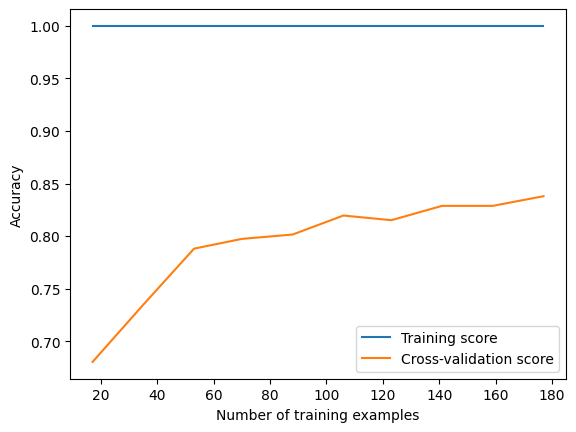

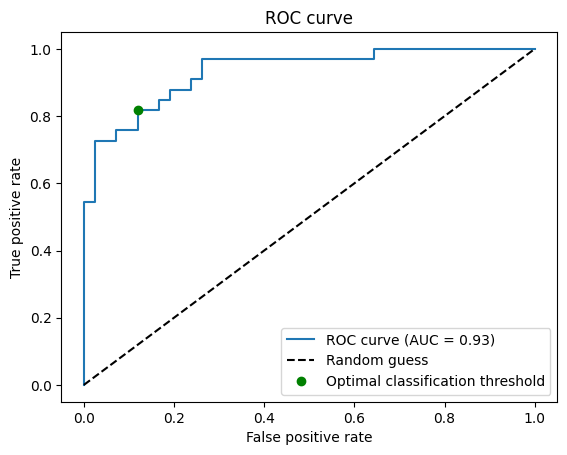

In [6]:
# Regularized KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

print("Regularized KNN")

# Hyperparameters to tune
params = {'n_neighbors': range(1, 31, 2), # start stop step
          'leaf_size': [1,2,3,4,5,10,20,30,40,50]}

knn_reg = KNeighborsClassifier(p=2, weights='distance')

grid_reg = GridSearchCV(knn_reg, params, cv=5, n_jobs=-1)
grid_reg.fit(X_train_scaled, y_train)
knn_reg = grid_reg.best_estimator_

print("Best hyperparameters: ", grid_reg.best_params_)

# Get predicted probabilities for the test set
y_prob = grid_reg.predict_proba(X_test_scaled)[:, 1]
# Compute false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate Euclidean distance to the top-left corner for each threshold
dist = np.sqrt(fpr**2 + (1-tpr)**2)
# Find index of threshold with minimum distance
idx = np.argmin(dist)
y_pred = (y_prob >= thresholds[idx]).astype(int)

print('Optimal classification threshold:', round(thresholds[idx], 2))
printResults(knn_reg, y_test, y_pred)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_reg,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)


# Calculate means and standard deviations for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training score")
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Compute AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.plot(fpr[idx], tpr[idx], 'go', label='Optimal classification threshold')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()